In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from os import listdir
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications import imagenet_utils
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from os import listdir

In [ ]:
def load_doc(filename):
    file = open(filename,'r')
    text = file.read()
    return text

In [ ]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return (dataset)

In [ ]:
# load training dataset (6K)
train_text_filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(train_text_filename)
print('Train-Dataset: %d' % len(train))

In [ ]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
print('\n','train_descriptions fromat:')
print(train_descriptions)

In [ ]:
model_weights_list=listdir('models/checks')
print('total number of models: ',len(model_weights_list))
dir ='models/checks/'
for mod in listdir(dir):
    dest = dir+'model-'+str(mod)[-16:]
    src  = dir+ mod
    print(src,'  -  ',dest)
    os.rename(src,dest)

In [ ]:
# sort the files
all_weights=sorted(listdir('models/checks/'))
print(all_weights)

In [ ]:
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))

In [ ]:
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))

In [ ]:
def load_photo_features(filename, dataset):
    # load all features
    features = load(open(filename, 'rb'))
    # filter features
    return features

In [ ]:
test_features = load_photo_features('encoded_test_images.pkl', test)
print('Photos: test=%d' % len(test_features))

In [ ]:
wordtoix= load(open('w2i.pkl','rb'))

In [ ]:
ixtoword= load(open('i2w.pkl','rb'))

In [ ]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(34):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=34)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final


In [18]:
# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a))
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,2048))
        yhat=greedySearch(image)
        
        
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\nBLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

a=0
li=list()
direc='models/checks'
for modwei in listdir(direc)[:10]:
    a=a+1
    modwei='models/checks/'+modwei
    model=load_model(modwei)
    print('model ',a,'/',len(listdir(direc)[:10]))
    print(modwei)
    start = time()
    li.append(evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34))
    print('Time taken for ',a,'th  model = ', time()-start,'\n')

model  1 / 10
models/checks/model-val_loss3.358.h5
1000BLEU -1:  0.46315976547754595
BLEU -2:  0.2831855093554703
BLEU -3:  0.19984684342867132
BLEU -4:  0.0980603938952402
Time taken for  1 th  model =  136.46433281898499 

model  2 / 10
models/checks/model-val_loss3.426.h5
1000BLEU -1:  0.45851896072080583
BLEU -2:  0.27909230846337985
BLEU -3:  0.19629762283413715
BLEU -4:  0.09799236090411483
Time taken for  2 th  model =  97.31748485565186 

model  3 / 10
models/checks/model-val_loss3.258.h5
1000BLEU -1:  0.47127029117936964
BLEU -2:  0.291939895822121
BLEU -3:  0.2079881334054854
BLEU -4:  0.10443409158414901
Time taken for  3 th  model =  93.72541332244873 

model  4 / 10
models/checks/model-val_loss3.715.h5
1000BLEU -1:  0.4523303868251169
BLEU -2:  0.2664006447027538
BLEU -3:  0.17750205173560932
BLEU -4:  0.08111046076372555
Time taken for  4 th  model =  97.11067128181458 

model  5 / 10
models/checks/model-val_loss3.315.h5
1000BLEU -1:  0.4605261779532613
BLEU -2:  0.279696

In [19]:
with open('check_score.pkl','wb') as pik:
    dump(li,pik)

In [20]:
scores = load(open('check_score.pkl','rb'))
y=scores

In [21]:
y1=list()
y2=list()
y3=list()
y4=list()
for i in y:
    y1.append(round(i[0],7)) 
    y2.append(round(i[1],7))
    y3.append(round(i[2],7))
    y4.append(round(i[3],7))

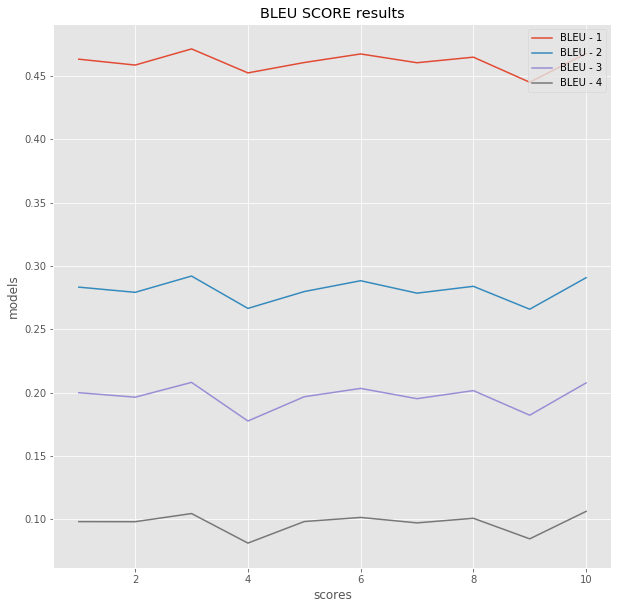

In [42]:
x=list(range(1,11))
plt.style.use("ggplot")
fig= plt.figure(figsize=(10,10))
plt.plot(x,y1,label='BLEU - 1')
plt.plot(x,y2,label='BLEU - 2')
plt.plot(x,y3,label='BLEU - 3')
plt.plot(x,y4,label='BLEU - 4')
plt.title('BLEU SCORE results')
plt.xlabel('scores')
plt.ylabel('models')
plt.legend()
plt.show()


In [ ]:
# Additional model evaluation.....

In [38]:
# evaluate the skill of the model
import sys
def evaluate_mod(x, model, descriptions, photos, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    a=0
    for key, desc_list in descriptions.items():
        # generate description---------------------------------------------------------
        a=a+1
        sys.stdout.write('\r'+str(a),)
        sys.stdout.flush()
        re_key=key+'.jpg'
        image = encoding_test[re_key].reshape((1,2048))
        yhat=greedySearch(image)
        
        
        # store actual and predicted------------------------------------------------------------
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
        
    a = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    b = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    c = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    d = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    print('\nBLEU -1: ',a)
    print('BLEU -2: ',b)
    print('BLEU -3: ',c)
    print('BLEU -4: ',d)
    

    return ([a,b,c,d])

In [35]:
model=load_model('models/mod_check/2.h5')
evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34)

helo
1000BLEU -1:  0.4595922037212486
BLEU -2:  0.2884743308869786
BLEU -3:  0.2061109841147742
BLEU -4:  0.10148361673021893


[0.4595922037212486,
 0.2884743308869786,
 0.2061109841147742,
 0.10148361673021893]

In [39]:
model=load_model('models/mod_check/2.h5')
model.load_weights('models/mod_check/1_wei.h5')
evaluate_mod(str(a),model, test_descriptions, test_features, max_length=34)

1000
BLEU -1:  0.4718570668236333
BLEU -2:  0.2948534933631161
BLEU -3:  0.2106061718498286
BLEU -4:  0.10688448837642955


[0.4718570668236333,
 0.2948534933631161,
 0.2106061718498286,
 0.10688448837642955]